# Notebook 2: Data Preprocessing
# Amazon Beauty Products - Recommendation System

In [129]:
%load_ext autoreload
%autoreload 2

import sys
import os
import warnings
from datetime import datetime
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, save_npz

# Thêm đường dẫn source code
sys.path.append(os.path.abspath('..'))

# Import các hàm từ module src (đã gộp các dòng import trùng lặp)
from src.data_processing import (
    load_data, clean_data, filter_data, 
    create_mappings, create_rating_matrix, split_data,
    compute_user_features, compute_product_features, compute_temporal_features,
    normalize_min_max, normalize_z_score, center_rating_matrix
)
from src.visualization import plot_preprocessing_summary

# Cấu hình hiển thị
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. TẢI VÀ LÀM SẠCH DỮ LIỆU

In [130]:
# 1. Load dữ liệu
print("Loading data...")
raw_data = load_data('../data/raw/ratings_Beauty.csv')

# 2. Làm sạch cơ bản
user_ids, product_ids, ratings, timestamps = clean_data(raw_data)

# 3. Lọc dữ liệu (Min ratings)
user_ids, product_ids, ratings, timestamps = filter_data(
    user_ids, product_ids, ratings, timestamps, 
    min_user_ratings=15, 
    min_product_ratings=12
)

# 4. Tạo Mappings (ID <-> Index)
user_to_idx, product_to_idx, idx_to_user, idx_to_product, user_indices, product_indices = create_mappings(user_ids, product_ids)

print("Data cleaning & mapping complete.")

Loading data...
✓ Loaded 2,023,070 ratings successfully

=== DATA CLEANING ===
Original size: 2,023,070
  Checking for duplicates...
  After cleaning: 2,023,070
  Removed: 0 (0.00%)

=== DATA FILTERING ===
Criteria: min_user_ratings=15, min_product_ratings=12
  Iteration 1: 100,650 ratings, 5,233 users, 21,655 products
  Iteration 2: 39,307 ratings, 2,926 users, 1,582 products
  Iteration 3: 25,054 ratings, 966 users, 1,130 products
  Iteration 4: 22,291 ratings, 883 users, 659 products
  Iteration 5: 21,230 ratings, 783 users, 635 products
  Iteration 6: 20,881 ratings, 774 users, 612 products
  Iteration 7: 20,715 ratings, 762 users, 612 products
  Iteration 8: 20,672 ratings, 762 users, 608 products
  Iteration 9: 20,658 ratings, 761 users, 608 products
  Iteration 10: 20,658 ratings, 761 users, 608 products
✓ Filtering complete

✓ Created mappings:
  Users: 0 to 760
  Products: 0 to 607
Data cleaning & mapping complete.


### 2. TRÍCH XUẤT ĐẶC TRƯNG

In [131]:
# 1. Tạo ma trận Rating
rating_matrix = create_rating_matrix(user_indices, product_indices, ratings)

# 2. Tính toán Features
print("Computing features...")
user_features = compute_user_features(rating_matrix)
product_features = compute_product_features(rating_matrix)
temporal_features = compute_temporal_features(ratings, timestamps)

print(f"User Features Shape: {user_features.shape}")
print(f"Product Features Shape: {product_features.shape}")
print(f"Temporal Features Shape: {temporal_features.shape}")


✓ Created rating matrix:
  Shape: (761, 608)
  Non-zero entries: 20,658
  Sparsity: 95.535220%
Computing features...

 Đang tính toán đặc trưng người dùng (User Features)...
  -> Shape: (761, 5)

 Đang tính toán đặc trưng sản phẩm (Product Features)...
  -> Shape: (608, 5)

 Đang tính toán đặc trưng thời gian (Temporal Features)...
  -> Shape: (20658, 4)
User Features Shape: (761, 5)
Product Features Shape: (608, 5)
Temporal Features Shape: (20658, 4)


### 3. CHUẨN HÓA DỮ LIỆU

In [132]:
print("\n[1] Performing Mean-Centering (Initial Check)...")
rating_matrix_centered, user_means = center_rating_matrix(rating_matrix)
print(f"User Means (Bias) Shape: {user_means.shape}")

print("\n[2] Chuẩn hóa Ratings (Min-Max):")
ratings_minmax = normalize_min_max(ratings)
print(f"  - Khoảng gốc:    [{np.min(ratings):.2f}, {np.max(ratings):.2f}]")
print(f"  - Khoảng MinMax: [{np.min(ratings_minmax):.2f}, {np.max(ratings_minmax):.2f}]")

print("\n[3] Chuẩn hóa Features (Z-score):")
user_features_normalized = normalize_z_score(user_features, axis=0)
product_features_normalized = normalize_z_score(product_features, axis=0)

print(f"  - User Features Norm Shape:    {user_features_normalized.shape}")
print(f"  - Product Features Norm Shape: {product_features_normalized.shape}")
print(f"  - Check User Mean: {np.mean(user_features_normalized, axis=0)}") 

print("\n[4] Mean-Centering Rating Matrix (Final):")
# Tính toán lại để đảm bảo biến lưu giá trị mới nhất
rating_matrix_centered, user_means = center_rating_matrix(rating_matrix)

nonzero_centered = rating_matrix_centered[rating_matrix_centered != 0]
print(f"  - Trung bình gốc (Ratings): {np.mean(ratings):.4f}")
print(f"  - Trung bình sau centering: {np.mean(nonzero_centered):.4f}")
print("   Đã loại bỏ thiên kiến người dùng (User Bias removed)")


[1] Performing Mean-Centering (Initial Check)...

--- Performing Mean-Centering ---
User Means (Bias) Shape: (761,)

[2] Chuẩn hóa Ratings (Min-Max):
  - Khoảng gốc:    [1.00, 5.00]
  - Khoảng MinMax: [0.00, 1.00]

[3] Chuẩn hóa Features (Z-score):
  - User Features Norm Shape:    (761, 5)
  - Product Features Norm Shape: (608, 5)
  - Check User Mean: [ 3.5686419e-08  5.2547642e-07 -1.3281027e-06  2.2596505e-07
  2.6238575e-07]

[4] Mean-Centering Rating Matrix (Final):

--- Performing Mean-Centering ---
  - Trung bình gốc (Ratings): 4.1675
  - Trung bình sau centering: 0.0000
   Đã loại bỏ thiên kiến người dùng (User Bias removed)


### 5. CHIA TẬP DỮ LIỆU

In [133]:
print("Splitting data...")
train_idx, val_idx, test_idx, train_matrix, val_matrix, test_matrix = split_data(
    user_indices, product_indices, ratings, 
    train_ratio=0.7, val_ratio=0.15, test_ratio=0.15
)
print("Data split complete.")

Splitting data...

=== DATA SPLITTING ===
Ratios: Train 70% | Val 15% | Test 15%

✓ Split complete:
  Train: 15,126 (73.2%)
  Val: 2,766 (13.4%)
  Test: 2,766 (13.4%)
Data split complete.


### 6.LƯU TRỮ

In [134]:
os.makedirs('../data/processed', exist_ok=True)
print("\n=== SAVING PROCESSED DATA ===")

# Lưu Sparse Matrices
save_npz('../data/processed/rating_matrix_sparse.npz', csr_matrix(rating_matrix))
save_npz('../data/processed/train_matrix_sparse.npz', csr_matrix(train_matrix))
save_npz('../data/processed/val_matrix_sparse.npz', csr_matrix(val_matrix))
save_npz('../data/processed/test_matrix_sparse.npz', csr_matrix(test_matrix))
print(" Đã lưu các ma trận (Sparse Matrices .npz)")

# Lưu Features gốc
np.save('../data/processed/user_features.npy', user_features)
np.save('../data/processed/product_features.npy', product_features)
np.save('../data/processed/temporal_features.npy', temporal_features)

# Lưu Normalized Features (nếu có)
if 'user_features_normalized' in locals():
    np.save('../data/processed/user_features_normalized.npy', user_features_normalized)
    np.save('../data/processed/product_features_normalized.npy', product_features_normalized)
print(" Đã lưu các file Features (.npy)")

# Lưu Mappings & Indices
np.save('../data/processed/user_to_idx.npy', user_to_idx)
np.save('../data/processed/product_to_idx.npy', product_to_idx)
np.save('../data/processed/idx_to_user.npy', idx_to_user)
np.save('../data/processed/idx_to_product.npy', idx_to_product)

np.save('../data/processed/train_indices.npy', train_idx)
np.save('../data/processed/val_indices.npy', val_idx)
np.save('../data/processed/test_indices.npy', test_idx)

# Lưu Ratings & Means
np.save('../data/processed/ratings.npy', ratings)
if 'user_means' in locals():
    np.save('../data/processed/user_means.npy', user_means)

print(" Đã lưu các file Mappings & Indices (.npy)")
print("\n Hoàn tất! Dữ liệu đã sẵn sàng cho Notebook 03.")


=== SAVING PROCESSED DATA ===
 Đã lưu các ma trận (Sparse Matrices .npz)
 Đã lưu các file Features (.npy)
 Đã lưu các file Mappings & Indices (.npy)

 Hoàn tất! Dữ liệu đã sẵn sàng cho Notebook 03.


### 7. TRỰC QUAN HÓA

✓ Đã lưu biểu đồ Preprocessing: ../data/processed/preprocessing_visualization.png


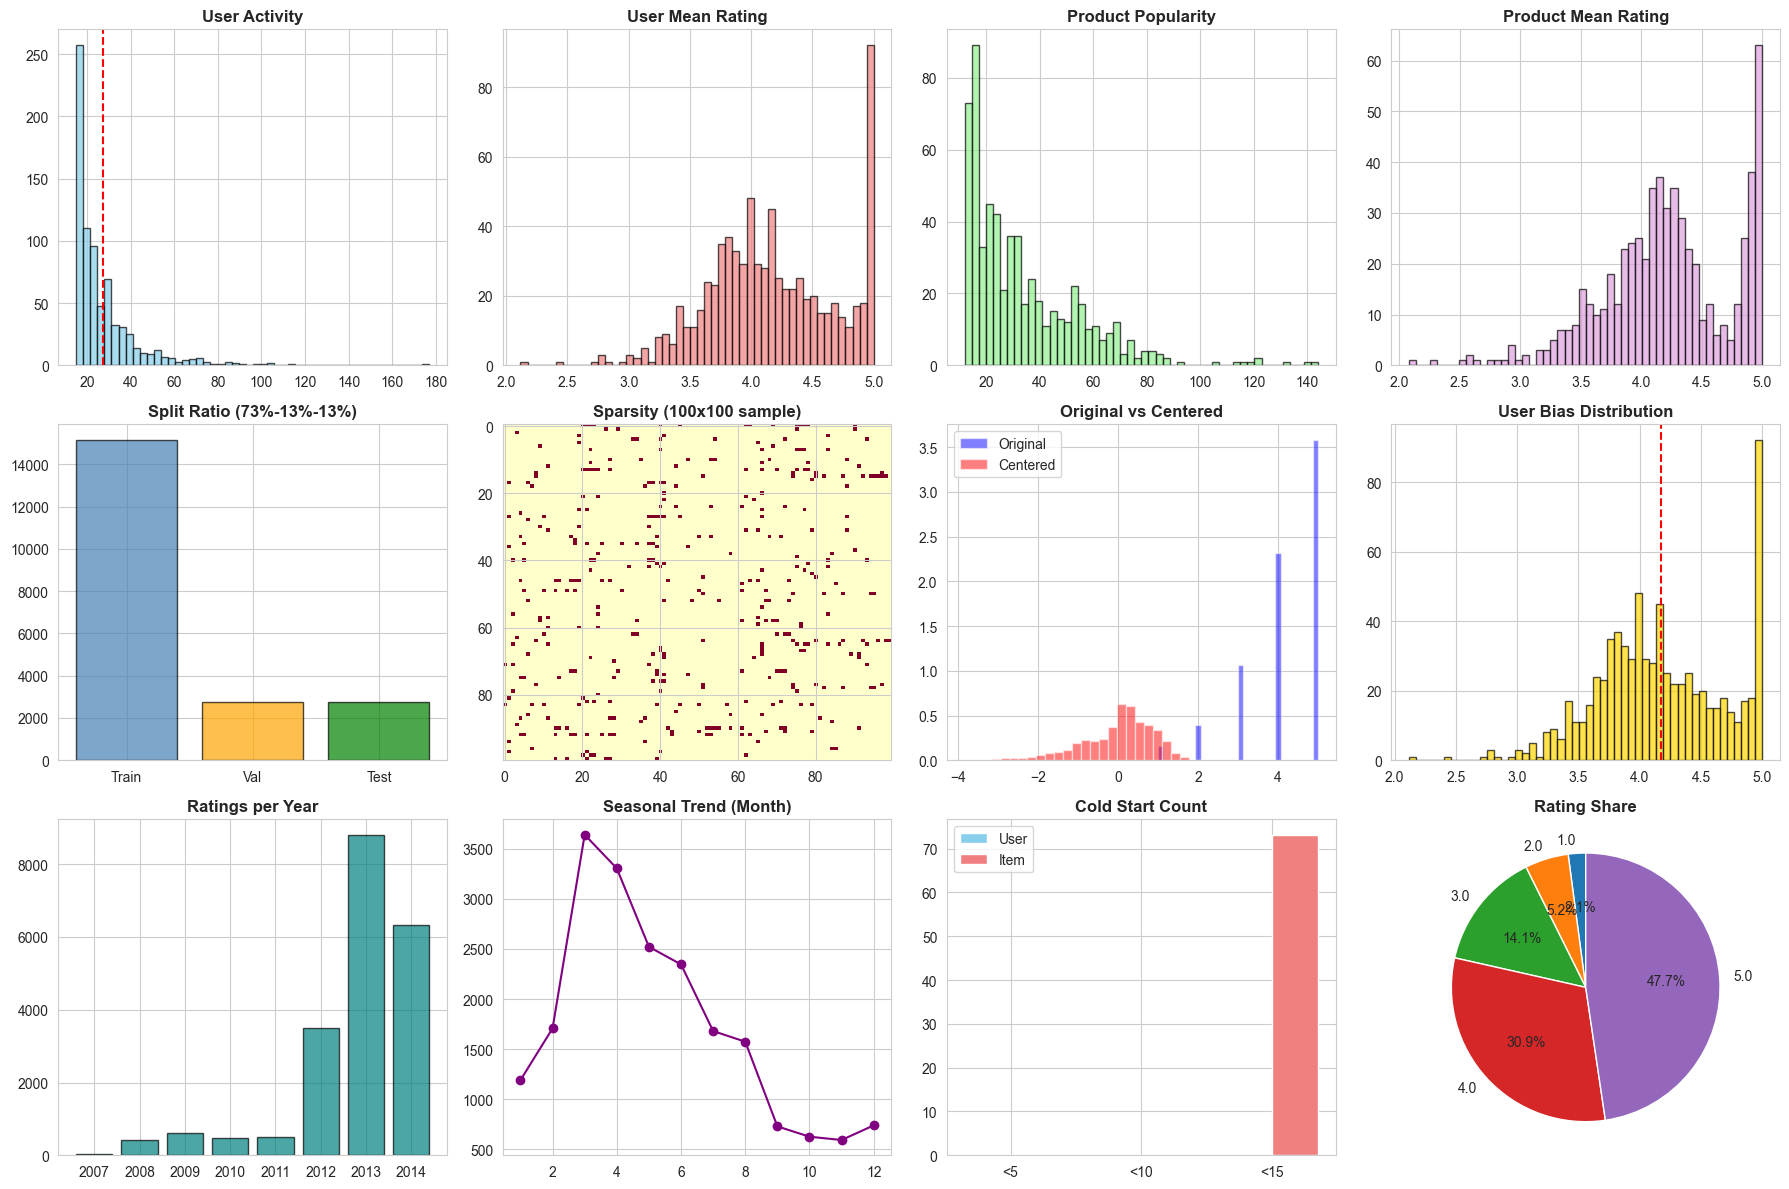

In [135]:
plot_preprocessing_summary(
    train_matrix, val_matrix, test_matrix, 
    user_features, product_features, 
    temporal_features, ratings, 
    rating_matrix,
    user_means=user_means,
    rating_matrix_centered=rating_matrix_centered,
    save_path='../data/processed/preprocessing_visualization.png'
)

### 8. BÁO CÁO TỔNG KẾT

In [136]:
# Tính toán lại các chỉ số cơ bản để báo cáo
n_users = rating_matrix.shape[0]
n_products = rating_matrix.shape[1]
n_ratings = np.count_nonzero(rating_matrix)
density = n_ratings / (n_users * n_products)
sparsity = 1 - density

print("="*40)
print(" BÁO CÁO TỔNG KẾT PREPROCESSING")
print("="*40)

print(f"\n 1. THỐNG KÊ DỮ LIỆU SAU XỬ LÝ:")
print(f"   ├─ Tổng số đánh giá: {len(ratings):,}")
print(f"   ├─ Số Users: {n_users:,}")
print(f"   ├─ Số Products: {n_products:,}")
print(f"   ├─ Kích thước ma trận: {rating_matrix.shape}")
print(f"   ├─ Độ thưa (Sparsity): {sparsity*100:.4f}%")
print(f"   └─ Mật độ (Density): {density*100:.4f}%")

print(f"\n 2. PHÂN BỐ RATING:")
for rating in [1.0, 2.0, 3.0, 4.0, 5.0]:
    count = np.sum(ratings == rating)
    print(f"   ├─ {rating:.0f}⭐: {count:,} ({count/len(ratings)*100:.2f}%)")

print(f"\n 3. PHÂN CHIA DỮ LIỆU:")
print(f"   ├─ Train: {len(train_idx):,} ({len(train_idx)/len(ratings)*100:.1f}%)")
print(f"   ├─ Validation: {len(val_idx):,} ({len(val_idx)/len(ratings)*100:.1f}%)")
print(f"   └─ Test: {len(test_idx):,} ({len(test_idx)/len(ratings)*100:.1f}%)")

print(f"\n 4. COLD START ANALYSIS (Phân tích khởi đầu lạnh):")
for threshold in [5, 10, 15, 20]:
    cold_u = np.sum(user_features[:, 0] < threshold)
    cold_p = np.sum(product_features[:, 0] < threshold)
    print(f"   ├─ Dưới {threshold} ratings:")
    print(f"   │   ├─ Users: {cold_u:,} ({cold_u/n_users*100:.1f}%)")
    print(f"   │   └─ Products: {cold_p:,} ({cold_p/n_products*100:.1f}%)")

print(f"\n 5. FEATURES ĐÃ TẠO:")
print(f"   ├─ User Features: {user_features.shape}")
print(f"   ├─ Product Features: {product_features.shape}")
print(f"   └─ Temporal Features: {temporal_features.shape}")

print(f"\n 6. TEMPORAL ANALYSIS:")
years = temporal_features[:, 1]
unique_years = np.unique(years)
if len(unique_years) > 0:
    best_year = int(unique_years[np.argmax([np.sum(years==y) for y in unique_years])])
    print(f"   ├─ Khoảng thời gian: {int(unique_years[0])} - {int(unique_years[-1])}")
    print(f"   └─ Năm có nhiều ratings nhất: {best_year}")

print(f"\n 7. THỐNG KÊ USER:")
print(f"   ├─ Số ratings TB/user: {np.mean(user_features[:, 0]):.2f}")
print(f"   ├─ Điểm TB của users: {np.mean(user_features[:, 1]):.2f}")
print(f"   ├─ User active nhất: {int(np.max(user_features[:, 0]))} ratings")
print(f"   └─ User ít hoạt động nhất: {int(np.min(user_features[:, 0]))} ratings")

print(f"\n 8. THỐNG KÊ PRODUCT:")
print(f"   ├─ Số ratings TB/product: {np.mean(product_features[:, 0]):.2f}")
print(f"   ├─ Điểm TB của products: {np.mean(product_features[:, 1]):.2f}")
print(f"   ├─ Product phổ biến nhất: {int(np.max(product_features[:, 0]))} ratings")
print(f"   └─ Product ít phổ biến nhất: {int(np.min(product_features[:, 0]))} ratings")

print(f"\n 9. CÁC FILE ĐÃ LƯU (../data/processed/):")
print(f"   ├─ Matrices: rating_matrix, train/val/test_matrix")
print(f"   ├─ Features: user/product/temporal features")
print(f"   ├─ Mappings: user/product mappings & indices")
print(f"   └─ Others: ratings")

print(f"\n 10. VISUALIZATION:")
print(f"    ✓ Đã lưu biểu đồ tại: ../data/processed/preprocessing_visualization.png")

 BÁO CÁO TỔNG KẾT PREPROCESSING

 1. THỐNG KÊ DỮ LIỆU SAU XỬ LÝ:
   ├─ Tổng số đánh giá: 20,658
   ├─ Số Users: 761
   ├─ Số Products: 608
   ├─ Kích thước ma trận: (761, 608)
   ├─ Độ thưa (Sparsity): 95.5352%
   └─ Mật độ (Density): 4.4648%

 2. PHÂN BỐ RATING:
   ├─ 1⭐: 432 (2.09%)
   ├─ 2⭐: 1,084 (5.25%)
   ├─ 3⭐: 2,920 (14.13%)
   ├─ 4⭐: 6,377 (30.87%)
   ├─ 5⭐: 9,845 (47.66%)

 3. PHÂN CHIA DỮ LIỆU:
   ├─ Train: 15,126 (73.2%)
   ├─ Validation: 2,766 (13.4%)
   └─ Test: 2,766 (13.4%)

 4. COLD START ANALYSIS (Phân tích khởi đầu lạnh):
   ├─ Dưới 5 ratings:
   │   ├─ Users: 0 (0.0%)
   │   └─ Products: 0 (0.0%)
   ├─ Dưới 10 ratings:
   │   ├─ Users: 0 (0.0%)
   │   └─ Products: 0 (0.0%)
   ├─ Dưới 15 ratings:
   │   ├─ Users: 0 (0.0%)
   │   └─ Products: 73 (12.0%)
   ├─ Dưới 20 ratings:
   │   ├─ Users: 294 (38.6%)
   │   └─ Products: 195 (32.1%)

 5. FEATURES ĐÃ TẠO:
   ├─ User Features: (761, 5)
   ├─ Product Features: (608, 5)
   └─ Temporal Features: (20658, 4)

 6. TEMPORAL